## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import make_interp_spline, BSpline

## Get Data

In [2]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read())
dat = pd.read_pickle('./data/processed/final/all-sched-enriched.pkl')
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,False,True
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,True,True,True,True,True,False,True


### Overview

In [3]:
n_flights = dat['weekly_flights'].sum()
operators = dat['operator'].unique()
n_operators = len(operators)
cities = list(set(dat['from'].tolist() + dat['to'].tolist()))
n_cities = len(cities)

print('In a week, %i operators run %i domestic flights into and out of %i Indian cities.\n' % 
      (n_operators, n_flights, n_cities))
print('A flight departs from and arrives into a different city, so the %i flights result in' % n_flights)
print('a weekly total of %i arrivals and departures.' % (2*n_flights))

In a week, 9 operators run 21953 domestic flights into and out of 102 Indian cities.

A flight departs from and arrives into a different city, so the 21953 flights result in
a weekly total of 43906 arrivals and departures.


### By Cities

<ul>
    <li>Create a new dataframe by wrangling dat to identify for each city, across all carriers:
        <ol>
            <li>weekly total number of movements (arrivals plus departures).
            <li>weekly capacity.
            <li>weekly estimated passengers
        </ol>
</ul>

Identify the top cities that account for 80% of each weekly totals.

In [23]:
weeklies_ = ['weekly_flights', 'weekly_capacity', 'weekly_est_pass']

from_flights = dat.groupby(['from'])[weeklies_].sum()
to_flights = dat.groupby(['to'])[weeklies_].sum()

sdat = pd.concat([from_flights, to_flights], axis = 1, ignore_index = True)
sdat = sdat.fillna(0, axis = 1, downcast = 'infer') # if there are no flights either from or to a city, 
                                                    # replace NA by 0
sdat = sdat.rename(columns = {0:'from_weekly_flights', 
                                            3:'to_weekly_flights',
                                            1:'from_weekly_capacity',
                                            4:'to_weekly_capacity',
                                            2:'from_weekly_est_pass',
                                            5:'to_weekly_est_pass'}, errors = 'raise')

sdat['total_weekly_mvmnts'] = sdat.apply(lambda row: row.from_weekly_flights + row.to_weekly_flights,axis = 1)
sdat['total_weekly_capacity'] = sdat.apply(lambda row: row.from_weekly_capacity + row.to_weekly_capacity, 
                                           axis = 1)
sdat['total_weekly_est_pass'] = sdat.apply(lambda row: row.from_weekly_est_pass + row.to_weekly_est_pass, 
                                           axis = 1)

sdat.head()

,from_weekly_flights,from_weekly_capacity,from_weekly_est_pass,to_weekly_flights,to_weekly_capacity,to_weekly_est_pass,total_weekly_mvmnts,total_weekly_capacity,total_weekly_est_pass
AGR,4,280,218,4,280,218,8,560,436
AGX,7,490,383,7,490,383,14,980,766
AIP,7,546,500,7,546,500,14,1092,1000
AJL,11,1342,1046,24,3782,3223,35,5124,4269
AMD,764,124123,109080,750,120574,105987,1514,244697,215067


In [72]:
def top_cities_feature(df, feature, threshold):
    '''
    
    Returns the list top cities (by code) that account for threshold percentage of weekly total of the 
    desired feature.
    
    '''
    
    df = df.sort_values(by = [feature], ascending = False)   
    total = df[feature].sum()
    top_cities = round(df[feature].cumsum()/total, 2)
        
    return top_cities[top_cities <= threshold].index.tolist()

#### Top Cities by Weekly Movements

20 cities account for 80% of weekly movements.

Cities accounting for 80% of weekly movements:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Jaipur', 'Lucknow', 'Patna', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore', 'Coimbatore', 'Bagdogra', 'Chandigarh'] 



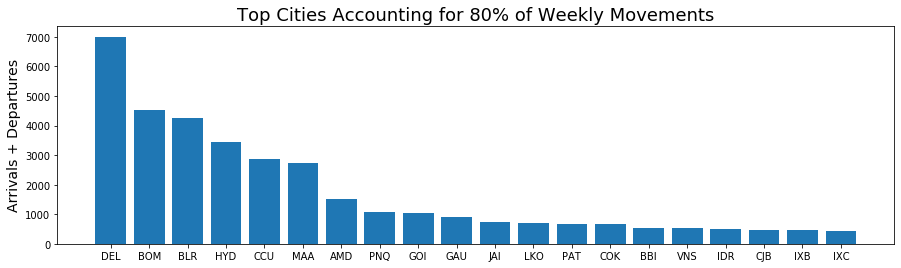

In [77]:
top_cities = top_cities_feature(sdat, 'total_weekly_mvmnts', 0.8)
top_cities_name = [codes_to_city[city] for city in top_cities]

print('%i cities account for 80%% of weekly movements.\n' % len(top_cities))
print('Cities accounting for 80% of weekly movements:\n', top_cities_name, '\n')

plt.figure(figsize = (15,4))
y = [sdat.iloc[sdat.index == city]['total_weekly_mvmnts'][0] for city in top_cities]
plt.bar(top_cities, y)
plt.title('Top Cities Accounting for 80% of Weekly Movements', size = 18)
plt.ylabel('Arrivals + Departures', size = 14)
plt.show()

#### Top Cities by Weekly Capacity

17 cities account for 80% of weekly capacity.

Cities accounting for 80% of weekly capacity:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Indore', 'Varanasi'] 



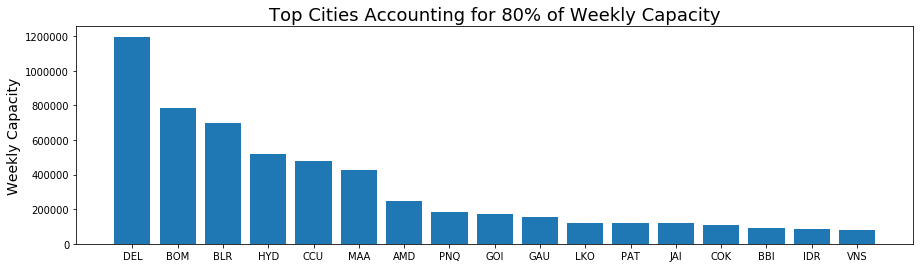

In [81]:
top_cities = top_cities_feature(sdat, 'total_weekly_capacity', 0.8)
top_cities_name = [codes_to_city[city] for city in top_cities]

print('%i cities account for 80%% of weekly capacity.\n' % len(top_cities))
print('Cities accounting for 80% of weekly capacity:\n', top_cities_name, '\n')

plt.figure(figsize = (15,4))
y = [sdat.iloc[sdat.index == city]['total_weekly_capacity'][0] for city in top_cities]
plt.bar(top_cities, y)
plt.title('Top Cities Accounting for 80% of Weekly Capacity', size = 18)
plt.ylabel('Weekly Capacity', size = 14)
plt.show()

#### Top Cities by Weekly Estimated Passengers

17 cities account for 80% of weekly estimated passengers.

Cities accounting for 80% of weekly estimated passengers:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore'] 



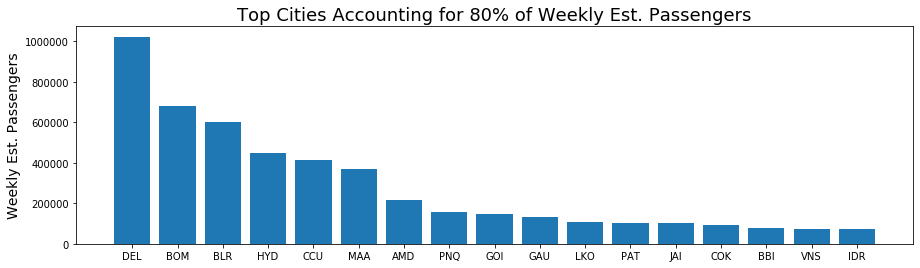

In [87]:
top_cities = top_cities_feature(sdat, 'total_weekly_est_pass', 0.8)
top_cities_name = [codes_to_city[city] for city in top_cities]

print('%i cities account for 80%% of weekly estimated passengers.\n' % len(top_cities))
print('Cities accounting for 80% of weekly estimated passengers:\n', top_cities_name, '\n')

plt.figure(figsize = (15,4))
y = [sdat.iloc[sdat.index == city]['total_weekly_est_pass'][0] for city in top_cities]
plt.bar(top_cities, y)
plt.title('Top Cities Accounting for 80% of Weekly Est. Passengers', size = 18)
plt.ylabel('Weekly Est. Passengers', size = 14)
plt.show()

#### Day-of-Week Distribution

<ul>
    <li>Plot the day-wise distribution for all arrivals and departures combined across all cities.
    <li>For the top cities by total weekly movements, for each city:
        <ol>
            <li>identify all schedules in and out of the city.
            <li>group the schedules by day of the week and count the total number of flights for the day.
            <li>plot the spread of the total daily movements for the city

In [106]:
def city_daily_mvmnts(df, city = 'ALL'):
    
    ''' 
    
    For a city, returns the count of inward, outward and total movements by day of week.
    
    When combined across all cities, for any day, the total number of arrivals must be equal to the total
    number of departures. However, this may not be true when considering a particular city, i.e. the total 
    number of arrivals in a city may not be the same as the total number of departures. 
    
    '''

    
    daily_mvmnts_in =[]
    daily_mvmnts_out = []
    daily_mvmnts = []
    
    if city == 'ALL':
        for i in range(1,8,1):
            day = 'day_' + str(i)
            daily_mvmnts_out.append(dat.groupby([day, 'from'])[day].count()[1].sum())
    
        daily_mvmnts = [value*2 for value in daily_mvmnts_out]
    
    else:    
        idx = [i for i in df.index if df['from'][i] == city or df['to'][i] == city]
        sdf = df.iloc[idx, :]

        idx_in = [i for i in sdf.index if sdf['from'][i] != city] # flights into the city
        idx_out = [i for i in sdf.index if sdf['to'][i] != city]  # flights out of the city

        for i in range(1,8,1):
            day = 'day_' + str(i)
            daily_mvmnts_in.append(sdf.loc[idx_in, :].groupby([day, 'from'])[day].count()[1].sum())
            daily_mvmnts_out.append(sdf.loc[idx_out, :].groupby([day, 'to'])[day].count()[1].sum())

        daily_mvmnts = [sum(x) for x in zip(daily_mvmnts_in, daily_mvmnts_out)]
    
    return daily_mvmnts_in, daily_mvmnts_out, daily_mvmnts
    

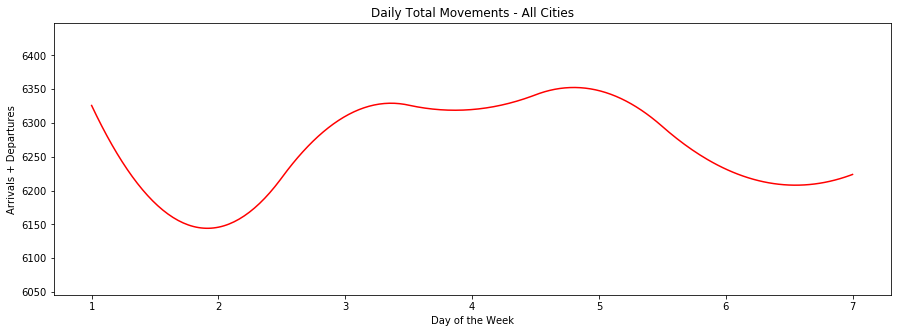

In [108]:
# For all cities combined

_, _, daily_mvmnts = city_daily_mvmnts(dat)

plt.figure(figsize = (15, 5))

# Setting up some defaults for plots
x_days = np.arange(1, 8 ,1)
x_axis = np.linspace(1, 7, 300)

spline = make_interp_spline(x_days, daily_mvmnts, k = 2)
y_axis = spline(x_axis)
plt.plot(x_axis, y_axis, color = 'red')
plt.ylim((min(daily_mvmnts) - 100, max(daily_mvmnts) + 100))
plt.xlabel('Day of the Week')
plt.ylabel('Arrivals + Departures')
plt.title('Daily Total Movements - All Cities')
plt.show()

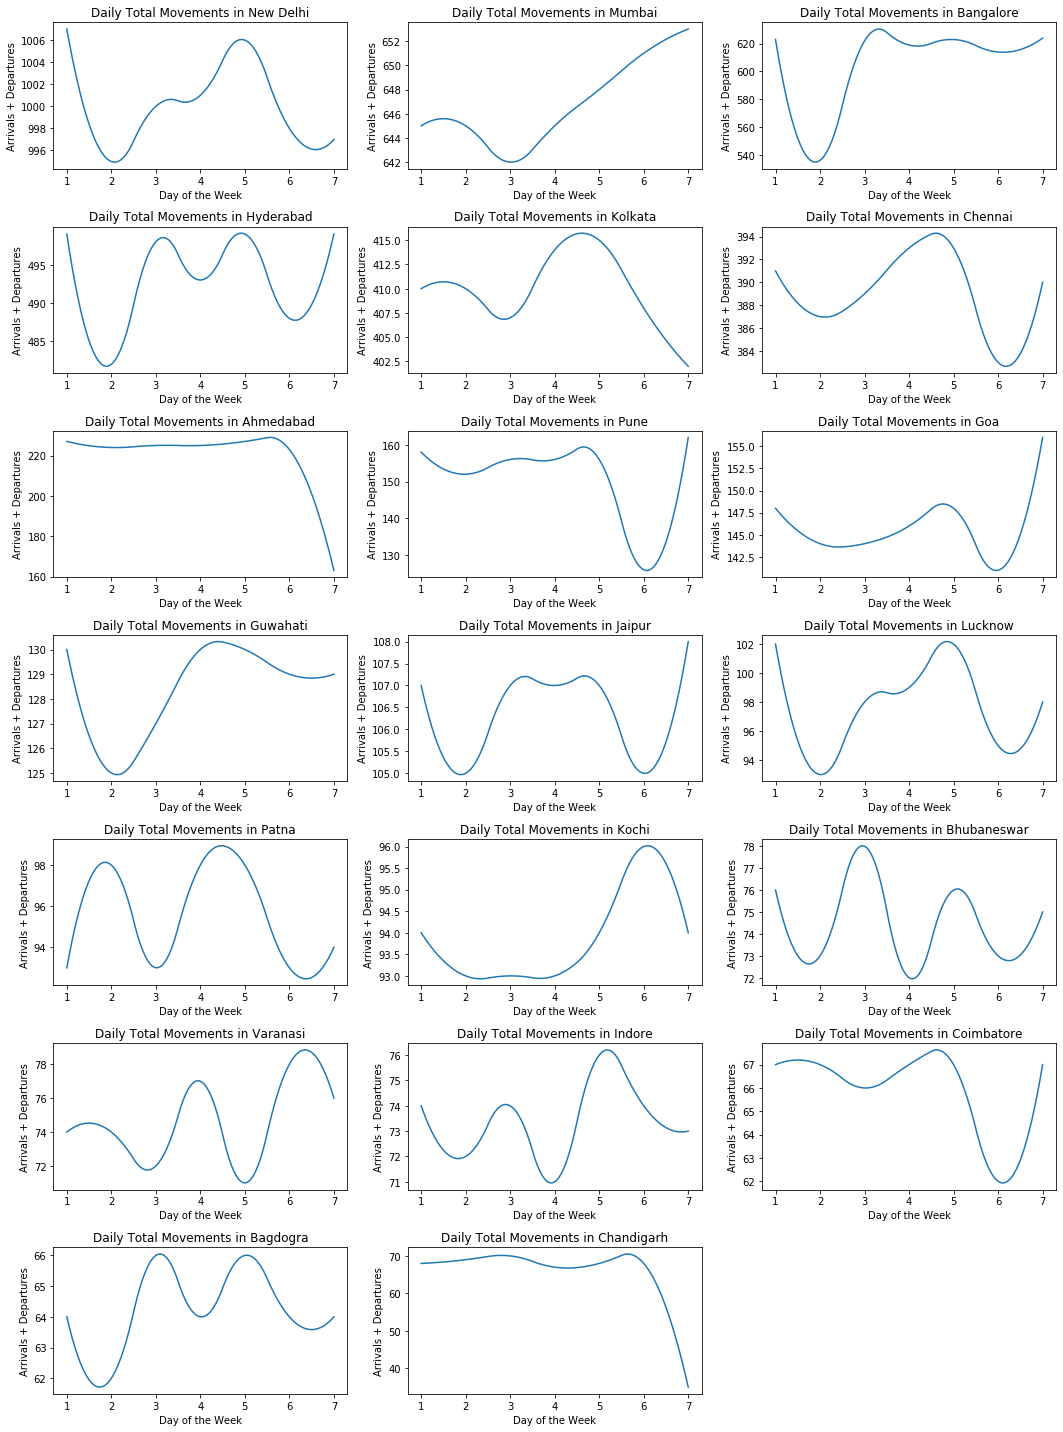

In [102]:
# For top cities by movements.

top_cities = top_cities_feature(sdat, 'total_weekly_mvmnts', 0.8)

plt.figure(figsize = (15, 20))

# Setting up some defaults for plots
ncol = 3
nrow = np.ceil(len(top_cities)/ncol)
subplt_id = 1
x_days = np.arange(1, 8 ,1)
x_axis = np.linspace(1, 7, 100)
   
for city in top_cities:
    _, _, daily_mvmnts = city_daily_mvmnts(dat, city)
      
    plt.subplot(nrow, ncol, subplt_id)
    subplt_id += 1
    
    spline = make_interp_spline(x_days, daily_mvmnts, k = 2)
    y_axis = spline(x_axis)
    plt.plot(x_axis, y_axis)
        
    plt.xlabel('Day of the Week')
    plt.ylabel('Arrivals + Departures')
    plt.title('Daily Total Movements in %s' % codes_to_city[city])

plt.tight_layout()
plt.show()

### Time-of-Day Distribution

In [1]:
def fill_missing(series, slots, na_val):
    
    '''
    
    In a series with an expected numerically ascending index, identifies if a particular index value
    is missing and inserts a new entry with such missing index value with the desired na_val.
    
    Finally, reorder the new series to ensure that the inserted index values are in their appropriate 
    position
    
    '''
    
    if series.shape[0] != slots:
        missing_idx = list(set(np.arange(1, slots+1, 1)).difference(series.index))
        for i in missing_idx:
            series[float(i)] = na_val
    
    series = series.sort_index()
    return series

In [2]:
def plot_hourly(timeslot_arr, timeslot_dep, city_name = 'All Cities'):
    
    '''
    
    Smoothes the timeslot_arr and timeslot_dep series using splines and then plots the series.
    
    '''
    
    x_timeslots = np.arange(1, 49, 1)
    x_axis = np.linspace(1, 48, 300)
    smoothing_param = 3
    
    spline = make_interp_spline(x_timeslots, timeslot_arr, k = smoothing_param)
    y_axis = np.maximum(np.zeros(300), spline(x_axis))
    plt.fill_between(x_axis, y_axis, label = 'arrivals', color = 'red', alpha = 0.5)
    
    spline = make_interp_spline(x_timeslots, timeslot_dep, k = smoothing_param)
    y_axis = np.maximum(np.zeros(300), spline(x_axis))
    plt.fill_between(x_axis, y_axis, label = 'departures', color = 'blue', alpha = 0.5)
    plt.xlim((1, 50))
    plt.xticks(np.arange(0, 49, 2), labels = np.arange(0, 25, 1)) # to get 24 hours on the x-axis
    plt.axvline(x = 12, color = 'grey', linestyle = '--')         # 6 a.m.
    plt.axvline(x = 24, color = 'grey', linestyle = '--')         # 12 noon
    plt.axvline(x = 36, color = 'grey', linestyle = '--')         # 6 p.m.
    plt.xlabel('Hour of the Day')
    plt.ylabel('Arrivals + Departures')
    plt.title('Hourly Movements for the Week - %s' % city_name)
    plt.legend()

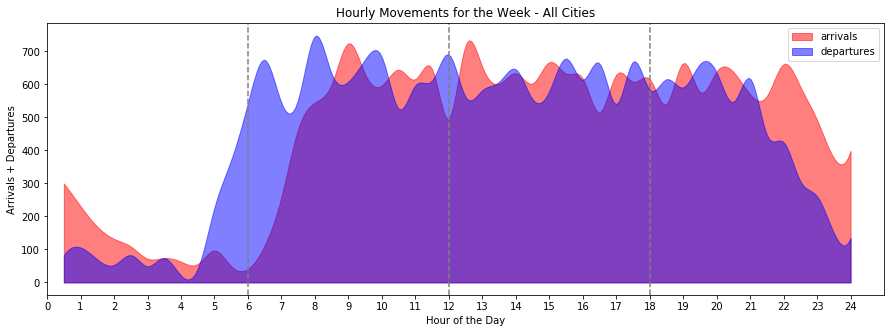

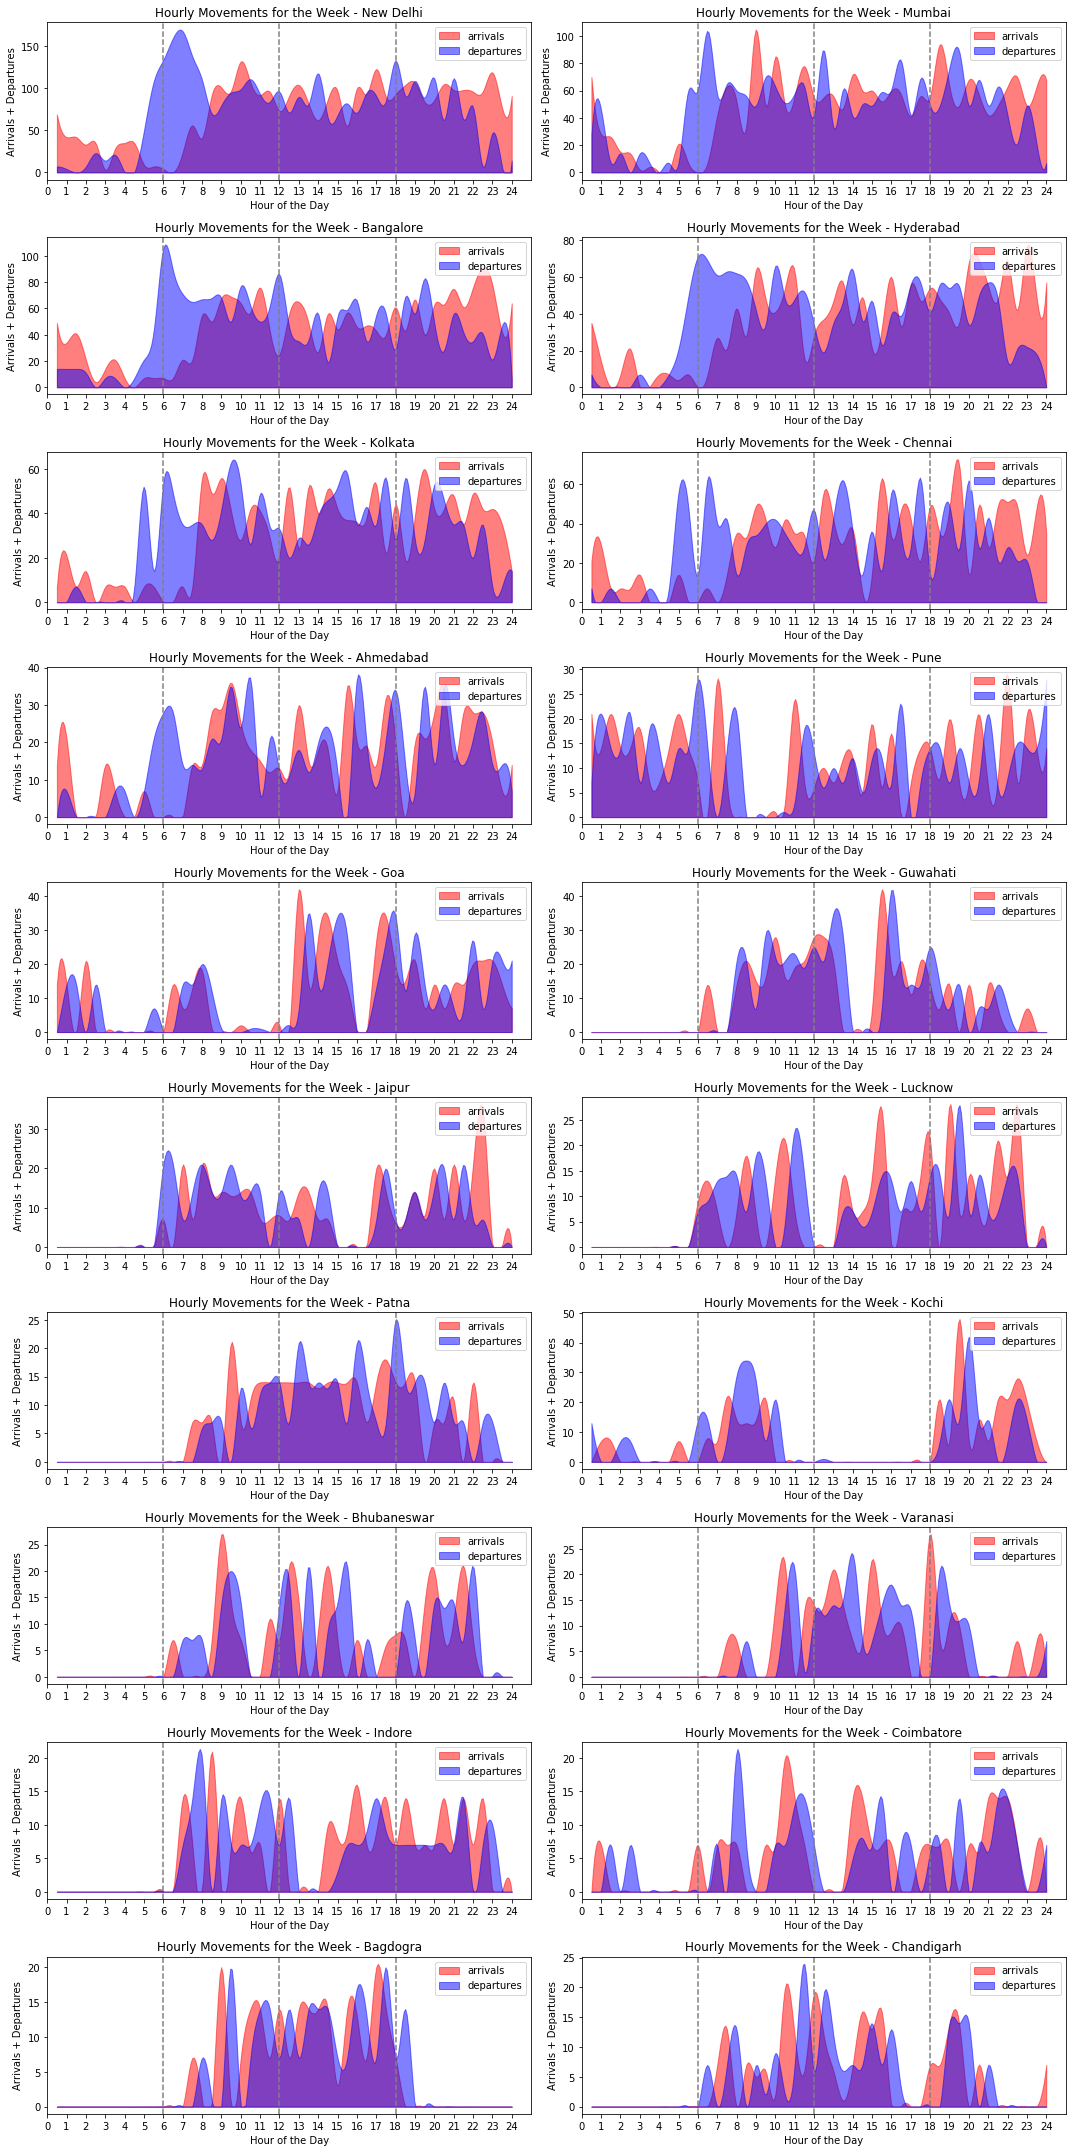

In [151]:
''' When combined across all cities, for any day, the total number of arrivals must be equal to the total 
number of departures. However, this may not be true when considering a particular city, i.e. the total number 
of arrivals in a city may not be the same as the total number of departures '''

plt.figure(figsize = (15, 5))

timeslot_arr = (dat.groupby(['to_time_slot'])['weekly_flights'].sum())
timeslot_arr = fill_missing(timeslot_arr, 48, 0)
timeslot_dep = (dat.groupby(['from_time_slot'])['weekly_flights'].sum())
timeslot_dep = fill_missing(timeslot_dep, 48, 0)

plot_hourly(timeslot_arr, timeslot_dep)
plt.show()

plt.figure(figsize = (15, 30))
ncol = 2
nrow = np.ceil(len(top_cities_by_mvmnts)/ncol)
subplot_= 1
for city_code in top_cities_by_mvmnts:
    timeslot_arr = []
    timeslot_dep = []
    
    idx = [i for i in dat.index if dat['from'][i] == city_code or dat['to'][i] == city_code]
    sdat = dat.iloc[idx, :]
        
    idx_in = [i for i in sdat.index if sdat['to'][i] == city_code] # flights into the city
    idx_out = [i for i in sdat.index if sdat['from'][i] == city_code]  # flights out of the city
    
    timeslot_arr = (sdat.loc[idx_in, :].groupby(['to_time_slot'])['weekly_flights'].sum())
    timeslot_arr = fill_missing(timeslot_arr, 48, 0)
    timeslot_dep = (sdat.loc[idx_out, :].groupby(['from_time_slot'])['weekly_flights'].sum())
    timeslot_dep = fill_missing(timeslot_dep, 48, 0)
    
    plt.subplot(nrow, ncol, subplot_)
    plot_hourly(timeslot_arr, timeslot_dep, codes_to_city[city_code])
    subplot_ += 1

plt.tight_layout()
plt.show()

### Time-of-Day Distribution by Passenger Movement

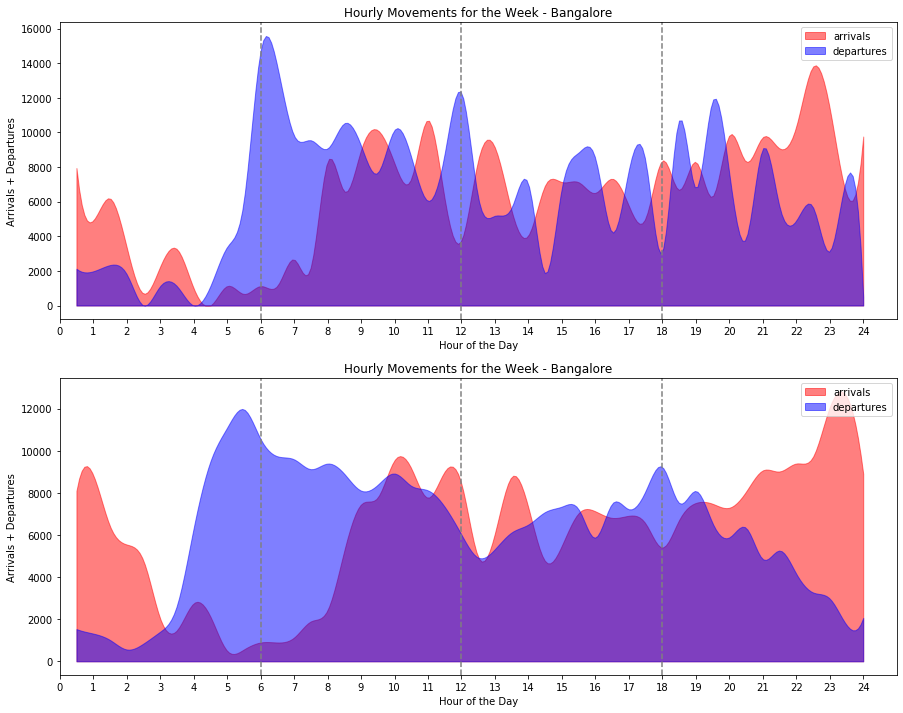

In [49]:
city_code = 'BLR'

timeslot_arr = []
timeslot_dep = []

idx = [i for i in dat.index if dat['from'][i] == city_code or dat['to'][i] == city_code]
sdat = dat.iloc[idx, :]

idx_in = [i for i in sdat.index if sdat['to'][i] == city_code] # flights into the city
idx_out = [i for i in sdat.index if sdat['from'][i] == city_code]  # flights out of the city

# Timeslot wise passenger traffic on incoming flights
pass_in_timeslot = (sdat.loc[idx_in, :].groupby(['to_time_slot'])['weekly_est_pass'].sum())
pass_in_timeslot = fill_missing(pass_in_timeslot, 48, 0)
#Timeslot wise passenger traffic on outgoing flights
pass_out_timeslot = (sdat.loc[idx_out, :].groupby(['from_time_slot'])['weekly_est_pass'].sum())
pass_out_timeslot = fill_missing(pass_out_timeslot, 48, 0)

'''Outgoing passengers start arriving at the airpot in 4 timeslots prior to the from_time_slot (evenly) and 
incoming passengers start departing from the airport in 2 slots post the to_time_slot (evenly). We adjust the 
timeslot passenger traffic values to reflect this spread.'''

in_slots = 2; out_slots = 4

pass_in_timeslot_adj = pd.Series(data = 0, index = pass_in_timeslot.index, dtype = 'float')
pass_out_timeslot_adj = pd.Series(data = 0, index = pass_out_timeslot.index, dtype = 'float')
        
for i in range(1, 49):              # spreading the passengers at the airport for incoming flights
    dist_ = pass_in_timeslot[i]/in_slots
    for j in range(i+1, i+3):
        if j > 48: j = j - 48
        pass_in_timeslot_adj[j] += dist_
        
for i in range(1, 49):              # spreading the passengers at the airport for outgoing flights
    dist_ = pass_out_timeslot[i]/out_slots
    for j in range(i-out_slots, i):
        if j < 1: j = 48 + j
        pass_out_timeslot_adj[j] += dist_

plt.figure(figsize = (15, 12))

plt.subplot(2, 1, 1)
plot_hourly(pass_in_timeslot, pass_out_timeslot, codes_to_city[city_code])

plt.subplot(2, 1, 2)
plot_hourly(pass_in_timeslot_adj, pass_out_timeslot_adj, codes_to_city[city_code])

plt.show()


In [40]:
print(timeslot_dep[47:], timeslot_dep_adj)

from_time_slot
47.0    7329.0
48.0     500.0
Name: weekly_est_pass, dtype: float64 from_time_slot
1.0     3914.5
2.0      250.0
3.0        0.0
4.0        0.0
5.0        0.0
6.0        0.0
7.0        0.0
8.0        0.0
9.0        0.0
10.0       0.0
11.0       0.0
12.0       0.0
13.0       0.0
14.0       0.0
15.0       0.0
16.0       0.0
17.0       0.0
18.0       0.0
19.0       0.0
20.0       0.0
21.0       0.0
22.0       0.0
23.0       0.0
24.0       0.0
25.0       0.0
26.0       0.0
27.0       0.0
28.0       0.0
29.0       0.0
30.0       0.0
31.0       0.0
32.0       0.0
33.0       0.0
34.0       0.0
35.0       0.0
36.0       0.0
37.0       0.0
38.0       0.0
39.0       0.0
40.0       0.0
41.0       0.0
42.0       0.0
43.0       0.0
44.0       0.0
45.0       0.0
46.0       0.0
47.0       0.0
48.0    3664.5
dtype: float64
